
In this notebook, You will do amazon review classification with BERT.[Download data from [this](https://www.kaggle.com/snap/amazon-fine-food-reviews/data) link]
<pre> 
It contains 5 parts as below.  Detailed instrctions are given in the each cell. please read every comment we have written. 
    1. Preprocessing 
    2. Creating a BERT model from the Tensorflow HUB.
    3. Tokenization
    4. getting the pretrained embedding Vector for a given review from the BERT.
    5. Using the embedding data apply NN and classify the reviews.
    6. Creating a Data pipeline for BERT Model. 

<font size=5>instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. 
    If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. please return outputs in the same format what we asked. Eg. Don't return List if we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>
</pre>

In this assignment you need two files reviews.csv and tokenization file.

You can use gdown module to import both the files in colab from Google drive the syntax is for gdown is `!gdown --id file_id`.

Please run the below cell to import the required files

```bash
!gdown --id 1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
!gdown --id 13exfXiyiByluh1PfYK1EyZyizqxeCVG9
```

In [1]:
# all imports

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
import os
import re
import shutil
import pickle
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
tf.test.gpu_device_name()
!nvidia-smi

Sat Aug 27 10:26:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   32C    P0    58W / 300W |    387MiB / 22731MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<font size=4>Grader function 1 </font>

In [3]:
def grader_tf_version():
    assert((tf.__version__)>'2')
    return True
grader_tf_version()

True

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [4]:
# Read the dataset - Amazon fine food reviews
reviews = pd.read_csv(r'Reviews.csv')

print(f'Shape of Reviews dataset : {reviews.shape}\n')

# check the info of the dataset
reviews.info()

Shape of Reviews dataset : (568454, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
reviews.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
# get only 2 columns - Text, Score
# drop the NAN values

reviews = reviews[['Text', 'Score']]
before_dropna = reviews.shape[0]

print('Missing value count on each columns')
print('-' * 35)
reviews.isnull().sum()

Missing value count on each columns
-----------------------------------


Text     0
Score    0
dtype: int64

In [7]:
reviews.dropna(axis = 0, how = 'any', inplace = True)
after_dropna = reviews.shape[0]

if before_dropna == after_dropna:
    print(f'There were no missing values in the selected dataframe : Dataframe size : {reviews.shape}')
else:
    print(f'Removed missing values : Dataframe size : {reviews.shape}')

There were no missing values in the selected dataframe : Dataframe size : (568454, 2)


In [8]:
reviews.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [9]:
reviews.iloc[43:53]

,Text,Score
43,McCann's Oatmeal is a good quality choice. Ou...,5
44,We really like the McCann's steel cut oats but...,5
45,This seems a little more wholesome than some o...,3
46,Good oatmeal. I like the apple cinnamon the b...,5
47,"The flavors are good. However, I do not see a...",3
48,I really like the Maple and Brown Sugar flavor...,4
49,This is the same stuff you can buy at the big ...,3
50,"This oatmeal is not good. Its mushy, soft, I d...",1
51,Got a free package of these with a bottle of b...,5
52,This wasn't in stock the last time I looked. I...,4


In [10]:
# if score> 3, set score = 1
# if score<=2, set score = 0
# if score == 3, remove the rows.

def scores_(data):
    if data > 3 : return 1
    elif data <= 2: return 0

reviews = reviews[reviews['Score'] != 3]    
reviews['Score'] = reviews['Score'].apply(scores_)
reviews.shape

(525814, 2)

In [11]:
reviews.iloc[43:53]

,Text,Score
43,McCann's Oatmeal is a good quality choice. Ou...,1
44,We really like the McCann's steel cut oats but...,1
46,Good oatmeal. I like the apple cinnamon the b...,1
48,I really like the Maple and Brown Sugar flavor...,1
50,"This oatmeal is not good. Its mushy, soft, I d...",0
51,Got a free package of these with a bottle of b...,1
52,This wasn't in stock the last time I looked. I...,1
54,I roast at home with a stove-top popcorn poppe...,1
55,We roast these in a large cast iron pan on the...,1
56,Deal was awesome! Arrived before Halloween as...,1


<font size=4>Grader function 2 </font>

In [12]:
def grader_reviews():
    temp_shape = (reviews.shape == (525814, 2)) and (reviews.Score.value_counts()[1]==443777)
    assert(temp_shape == True)
    return True

grader_reviews()

True

In [13]:
def get_wordlen(x):
    return len(x.split())

reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state = 30)

In [14]:
# remove HTML from the Text column and save in the Text column only
# print head 5

def re_html(data):
    return re.sub(r'<.*?>', '', data)

reviews['Text'] = reviews['Text'].apply(re_html)

reviews.head()

,Text,Score,len
64117,The tea was of great quality and it tasted lik...,1,30
418112,My cat loves this. The pellets are nice and s...,1,31
357829,Great product. Does not completely get rid of ...,1,41
175872,This gum is my favorite! I would advise every...,1,27
178716,I also found out about this product because of...,1,22


In [15]:
# split the data into train and test data(20%) with Stratify sampling, random state 33
X = reviews['Text']
y = reviews['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 33,
                                                    stratify = y)

In [16]:
# Reference
# https://stackoverflow.com/a/52338192

from IPython.display import IFrame
IFrame(src='https://miro.medium.com/max/1400/1*pGXcQtiiRxLubaEbH2QqOg.png',
                                                               width = 700, height = 250)

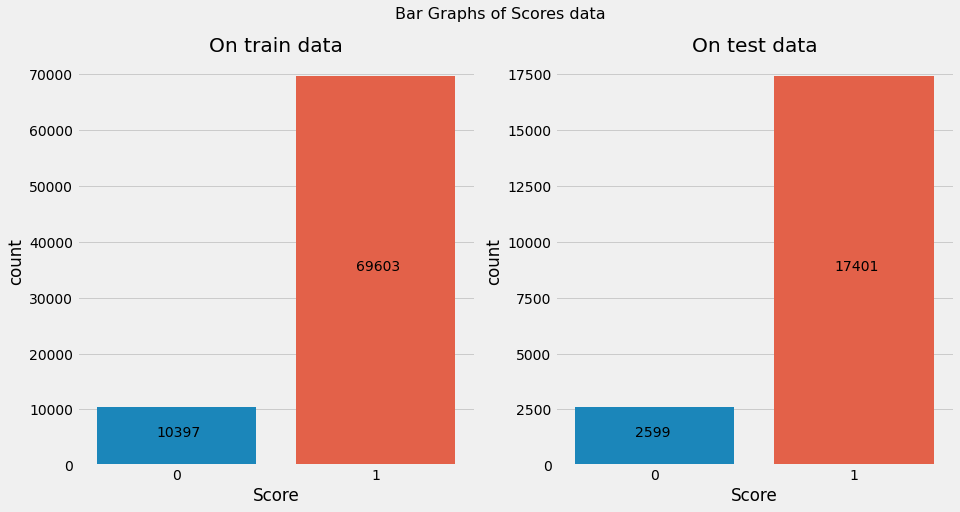

In [17]:
# Plot bar graphs of y_train and y_test
# https://stackoverflow.com/a/60088930

def plot_bar(col, axx, title):
    
    countP = sns.countplot(col, ax = axx)
    for i in col.unique():
        countP.annotate((col == i).sum(), (i - 0.1, (col == i).sum() // 2))
    countP.set(title = title)
    
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Bar Graphs of Scores data', fontsize = 16)

plot_bar(y_train, axes[0], 'On train data')
plot_bar(y_test, axes[1], 'On test data')

In [18]:
if os.path.exists('preprocessed_data'):
    shutil.rmtree('preprocessed_data')
    
os.mkdir('preprocessed_data')

In [19]:
# Saving to disk. if we need, we can load preprocessed data directly. 

reviews.to_csv('preprocessed_data/preprocessed.csv', index = False)

<pre><font size=6>Part-2: Creating BERT Model</font> 

If you want to know more about BERT, You can watch live sessions on Transformers and BERt. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [20]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,),
                                           dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,),
                                           dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,),
                                            dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1',
                                            trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [21]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',         

In [22]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

<pre><font size=6>Part-3: Tokenization</font></pre>

In [23]:
# getting Vocab file

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [24]:
import tokenization # We have given tokenization.py file

Create tokenizer **Instantiate FullTokenizer**, name must be `tokenizer`<br>
The FullTokenizer takes two parameters<br>
1. vocab_file and
2. do_lower_case

We have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )<br>
Please check the "tokenization.py" file the complete implementation

In [25]:
# if you are getting error for sentencepiece module you can install it using
# below command while running this cell for the first time
# !pip install sentencepiece

tokenizer = tokenization.FullTokenizer(vocab_file,do_lower_case )

<font size=4>Grader function 3 </font>

In [26]:
# it has to give no error 

def grader_tokenize(tokenizer):
    
    out = False
    try:
        out = ('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)
    except:
        out = False
    assert(out == True)
    return out

grader_tokenize(tokenizer)

True

Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 

add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)

if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)

Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask

Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)

type of all the above arrays should be numpy arrays

after execution of this cell, you have to get<br>
X_train_tokens, X_train_mask, X_train_segment<br>
X_test_tokens, X_test_mask, X_test_segment

#### Example
<img src = 'https://i.imgur.com/5AhhmgU.png'>

In [27]:
max_seq_length = 55

print(f'Original Sentence :\n\t\t{X_train.values[0].split()}')
print(f'\nNumber of words : {len(X_train.values[0].split())}\n')
print('=' * 50)

tokenz = tokenizer.tokenize(X_train.values[0])
if len(tokenz) >= max_seq_length - 2:
    tokenz = tokenz[:max_seq_length-2]
tokenz = ['[CLS]', *tokenz, '[SEP]']

print(f'\nTokens are\t: {tokenz}')
print(f'\nTokens length\t: {len(tokenz)}\n')
print('=' * 50)

pad_length = max_seq_length - len(tokenz)
if pad_length > 0:
    pads = ['[PAD]'] * pad_length
    tokenz_padded = tokenz + pads
else:
    tokenz_padded = tokenz

print(f'\nPadded Tokens are\t: {tokenz_padded}')
print(f'\nPadded Tokens length\t: {len(tokenz_padded)}\n')
print('=' * 50)

positional_tokenz = np.array(tokenizer.convert_tokens_to_ids(tokenz))
mask_array = np.array([1] * len(tokenz) + [0] * pad_length)    
seg_array = np.array([0] * max_seq_length)

print(f'\nTokens replaced with positional encoding :\n\t\t{positional_tokenz}')
print(f'\nThe maske array is :\n\t\t{mask_array}')
print(f'\nThe segment array is :\n\t\t{seg_array}')

Original Sentence :
		['I', 'had', 'never', 'tried', 'this', 'brand', 'before,', 'so', 'I', 'was', 'worried', 'about', 'the', 'quality.', 'It', 'tasted', 'great.', 'A', 'very', 'nice', 'smooth', 'rich', 'full', 'flavor.', 'Its', 'my', 'new', 'favoret.']

Number of words : 28


Tokens are	: ['[CLS]', 'i', 'had', 'never', 'tried', 'this', 'brand', 'before', ',', 'so', 'i', 'was', 'worried', 'about', 'the', 'quality', '.', 'it', 'tasted', 'great', '.', 'a', 'very', 'nice', 'smooth', 'rich', 'full', 'flavor', '.', 'its', 'my', 'new', 'favor', '##et', '.', '[SEP]']

Tokens length	: 36


Padded Tokens are	: ['[CLS]', 'i', 'had', 'never', 'tried', 'this', 'brand', 'before', ',', 'so', 'i', 'was', 'worried', 'about', 'the', 'quality', '.', 'it', 'tasted', 'great', '.', 'a', 'very', 'nice', 'smooth', 'rich', 'full', 'flavor', '.', 'its', 'my', 'new', 'favor', '##et', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

In [28]:
max_seq_length = 55

def tokenize_data(data, max_len):
    
    positional_tokenz = np.zeros((data.shape[0], max_len))
    mask_array = np.zeros((data.shape[0], max_len))
    # positional_tokenz = []
    # mask_array = []
    seg_array = np.zeros((data.shape[0], max_len))

    for i in tqdm(range(data.shape[0])):
        
        tokenz = tokenizer.tokenize(data.values[i])
        
        if len(tokenz) >= max_len - 2:
            tokenz = tokenz[:max_len-2]
        tokenz = ['[CLS]', *tokenz, '[SEP]']

        pad_length = max_len - len(tokenz)
        if pad_length > 0:
            pads = ['[PAD]'] * pad_length
            tokenz_padded = tokenz + pads
        else:
            tokenz_padded = tokenz

        positional_tokenz[i] = np.array(tokenizer.convert_tokens_to_ids(tokenz) + [0] * pad_length)
        mask_array[i] = np.array([1] * len(tokenz) + [0] * pad_length)
        
    return positional_tokenz, mask_array, seg_array

X_train_tokens, X_train_mask, X_train_segment = tokenize_data(X_train, max_seq_length)
X_test_tokens, X_test_mask, X_test_segment = tokenize_data(X_test, max_seq_length)

100%|██████████| 20000/20000 [00:09<00:00, 2169.41it/s]


In [29]:
# Save all your results to disk so that, no need to run all again. 

pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),
                                        open('preprocessed_data/train_data.pkl', 'wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),
                                        open('preprocessed_data/test_data.pkl', 'wb'))

In [30]:
# You can load from disk

# X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = \
#                         pickle.load(open('preprocessed_data/train_data.pkl', 'rb'))
# X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = \
#                         pickle.load(open('preprocessed_data/test_data.pkl', 'rb'))

<font size=4>Grader function 4 </font>

In [31]:
def grader_alltokens_train():
    out = False
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and \
                        (X_train_mask.shape[1]==max_seq_length) and \
                        (X_train_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out == True)
    
    return out

grader_alltokens_train()

True

<font size=4>Grader function 5 </font>

In [32]:
def grader_alltokens_test():
    
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and \
                        (X_test_mask.shape[1]==max_seq_length) and \
                        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment)
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    
    return out

grader_alltokens_test()

True

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [33]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [34]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [35]:
# get the train output, BERT model will give one output so save in X_train_pooled_output
# this cell will take some time to execute, make sure thay you have stable internet connection

X_train_pooled_output = bert_model.predict([X_train_tokens, X_train_mask, X_train_segment])
X_train_pooled_output.shape

2500/2500 [==============================] - 93s 36ms/step


(80000, 768)

In [36]:
# get the test output, BERT model will give one output so save in X_test_pooled_output

X_test_pooled_output = bert_model.predict([X_test_tokens, X_test_mask, X_test_segment])
X_test_pooled_output.shape

625/625 [==============================] - 23s 36ms/step


(20000, 768)

In [37]:
# save all your results to disk so that, no need to run all again.

pickle.dump((X_train_pooled_output, X_test_pooled_output),
                            open('preprocessed_data/final_output.pkl', 'wb'))

In [38]:
# X_train_pooled_output, X_test_pooled_output = pickle.load(open('preprocessed_data/final_output.pkl', 'rb'))

<font size=4>Grader function 6 </font>

In [39]:
# now we have X_train_pooled_output, y_train, X_test_pooled_ouput, y_test

#please use this grader to evaluate

def greader_output():
    
    assert(X_train_pooled_output.shape[1] == 768)
    assert(len(y_train) == len(X_train_pooled_output))
    assert(X_test_pooled_output.shape[1] == 768)
    assert(len(y_test) == len(X_test_pooled_output))
    assert(len(y_train.shape) == 1)
    assert(len(X_train_pooled_output.shape) == 2)
    assert(len(y_test.shape) == 1)
    assert(len(X_test_pooled_output.shape) == 2)
    return True

greader_output()

True

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> You have to use AUC as metric. Do not use tf.keras.metrics.AUC</b> 
<b> You have to write custom code for AUC and print it at the end of each epoch</b> 
2. You can use any architecture you want. 
3. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
4. Print the loss and metric at every epoch. 
5. You have to submit without overfitting and underfitting. 
</pre>

In [40]:
# imports

from datetime import datetime

from sklearn.metrics import roc_auc_score

from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [41]:
# create an Neural Network and train your model on X_train_pooled_output and y_train you can start as follows
# input_layer=Input(shape=(X_train_pooled_output.shape[1],))

tf.keras.backend.clear_session()
np.random.seed(152)
tf.random.set_seed(152)

input_layer=Input(shape=(X_train_pooled_output.shape[1], ))
x = Dense(2048, activation = 'relu', name = 'Dense1')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(1024, activation = 'relu', name = 'Dense2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu', name = 'Dense3')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation = 'relu', name = 'Dense4')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outP = Dense(1, activation = 'sigmoid', name = 'CL_Dense')(x)

model_ = Model(inputs = input_layer, outputs = outP)
model_.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 Dense1 (Dense)              (None, 2048)              1574912   
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 Dense2 (Dense)              (None, 1024)              2098176   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                             

In [42]:
if os.path.exists('logs'): shutil.rmtree('logs')
if os.path.exists('model_weights'): shutil.rmtree('model_weights')

In [43]:
logdir = 'logs/' + datetime.now().strftime('%Y%m%d_%H%M')
tensorBoard = TensorBoard(log_dir = logdir, histogram_freq = 1)

filepath = 'model_weights/EPO_{epoch:02d}-AUC_{val_auc:.4f}.hdf5'
modelCheck = ModelCheckpoint(filepath, monitor = 'val_auc', verbose = 1, save_best_only = True)

reduceLR = ReduceLROnPlateau(monitor = 'val_auc', factor = 0.8,
                                             patience = 2, verbose = 1, min_delta = 0.0001)

CallBackList = [tensorBoard, modelCheck, reduceLR]

In [44]:
# https://stackoverflow.com/a/69248506

def roc_score_(y_true, y_pred):
    
    if len(np.unique(y_true)) == 1:
        return 0.5
    return roc_auc_score(y_true, y_pred, average = 'micro')

def auc(y_true, y_pred):
    
    return tf.py_function(roc_score_, (y_true, y_pred), tf.double)

In [45]:
# https://keras.io/api/models/model_training_apis/
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC

EPOCHS = 20

model_.compile(optimizer = 'adam', metrics = [auc], loss = 'BinaryCrossentropy')
mod = model_.fit(X_train_pooled_output, y_train, epochs = EPOCHS, batch_size = 128,
                    validation_data = (X_test_pooled_output, y_test), callbacks = CallBackList)

Epoch 1/20
619/625 [============================>.] - ETA: 0s - loss: 0.3134 - auc: 0.8750
Epoch 1: val_auc improved from inf to 0.92390, saving model to model_weights/EPO_01-AUC_0.9239.hdf5
625/625 [==============================] - 4s 5ms/step - loss: 0.3122 - auc: 0.8756 - val_loss: 0.2146 - val_auc: 0.9239 - lr: 0.0010
Epoch 2/20
616/625 [============================>.] - ETA: 0s - loss: 0.1926 - auc: 0.9440
Epoch 2: val_auc did not improve from 0.92390
625/625 [==============================] - 3s 5ms/step - loss: 0.1926 - auc: 0.9441 - val_loss: 0.2267 - val_auc: 0.9392 - lr: 0.0010
Epoch 3/20
624/625 [============================>.] - ETA: 0s - loss: 0.1795 - auc: 0.9525
Epoch 3: val_auc did not improve from 0.92390

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
625/625 [==============================] - 3s 5ms/step - loss: 0.1795 - auc: 0.9525 - val_loss: 0.1990 - val_auc: 0.9501 - lr: 0.0010
Epoch 4/20
618/625 [============================>.] - ETA

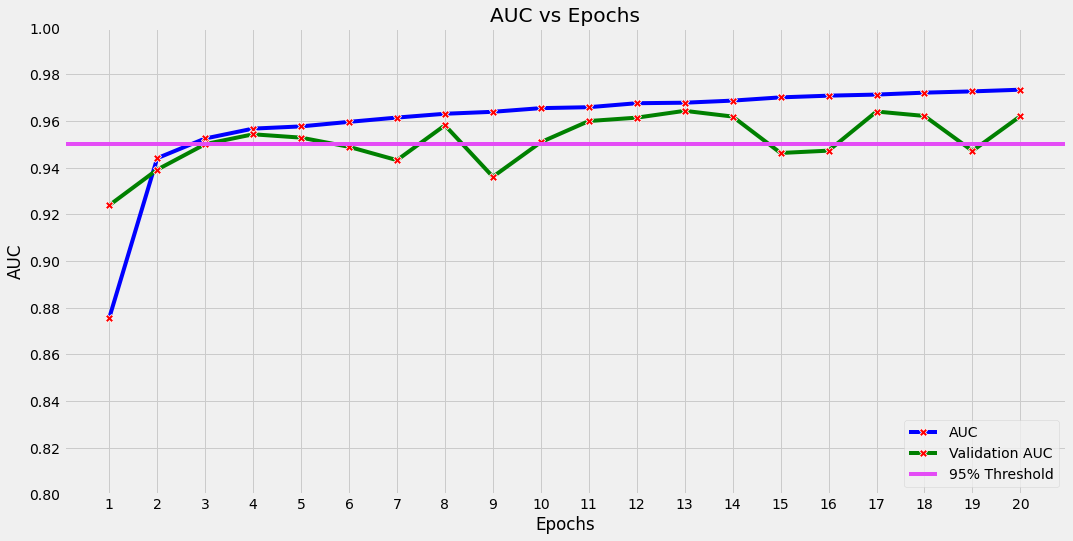

In [46]:
epochs_ = np.arange(1, len(mod.history['auc']) + 1)
plt.figure(figsize = (16, 8))
sns.lineplot(y = 'auc', data = mod.history , x = epochs_, label = 'AUC', color = 'b',
                                 marker = 'X', mfc = 'red', ms = 8)
sns.lineplot(y = 'val_auc', data = mod.history , x = epochs_, label = 'Validation AUC',
                                 color = 'g', marker = 'X', mfc = 'red', ms = 8)
plt.axhline(0.95, color = '#E44CF6', label = '95% Threshold')
plt.title('AUC vs Epochs')
plt.xticks(epochs_)
plt.yticks(np.arange(0.8, 1.01 , 0.02))
plt.xlabel('Epochs') ; plt.ylabel('AUC')
plt.legend(loc = 4) ; plt.show()

<Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 
1. Pipeline is a way to codify and automate the workflow.
2. Download the test.csv file from here <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a> </pre>


In [47]:
# there is an alterante way to load files from Google drive directly to your Colab session
# you can use gdown module to import the files as follows
# for example for test.csv you can write your code as
# !gdown --id file_id (remove the # from next line and run it)

In [48]:
# read the csv file

test_df = pd.read_csv('test.csv')
test_df.head(3)

,Text
0,Just opened Greenies Joint Care (individually ...
1,This product rocks :) My mom was very happy w/...
2,"The product was fine, but the cost of shipping..."


<Pre>1. You have to write a function that takes the test_df,trained model and the required parameters as input. 
2. Perform all the preproceesing steps inside the function.
- Remove all the html tags
- Now do tokenization [Part 3 as mentioned above]
- Create tokens,mask array and segment array
- Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
- Print the shape of output(X_test.shape).You should get (352,768)
3. Predit the output of X_test with the neural network model which we trained earlier.

4. Return the occurences of class labels from the function.
The output should be the count of datapoints classified as 1 or 0.

</pre>

In [49]:
# TensorFlow squeeze: Use tf squeeze to remove a dimension from Tensor
# https://youtu.be/EZbaoGGJF2g?t=104

def data_pipeline(df, NN_model):
    
    df['Text']  = df['Text'].apply(lambda text : re.sub(r'<.*?>', '', text))
    Test_tokens, Test_mask, Test_segment = tokenize_data(df['Text'], max_seq_length)
    X_test = bert_model.predict([Test_tokens, Test_mask, Test_segment])
    if X_test.shape == (352, 768):
        print(f'\nShape of "X_test" : {X_test.shape}\n')
    test_model_pred = tf.squeeze(NN_model.predict(X_test))
    return np.where(test_model_pred >= 0.5, 1, 0).tolist()

test_pred = np.array((data_pipeline(test_df, model_)))
print('\nCalss Labels generated from "test.csv" :')
print('=' * 40); print(test_pred[:10])

100%|██████████| 352/352 [00:00<00:00, 2094.48it/s]


11/11 [==============================] - 1s 36ms/step

Shape of "X_test" : (352, 768)

11/11 [==============================] - 0s 1ms/step

Calss Labels generated from "test.csv" :
[0 1 1 1 1 1 0 1 1 1]


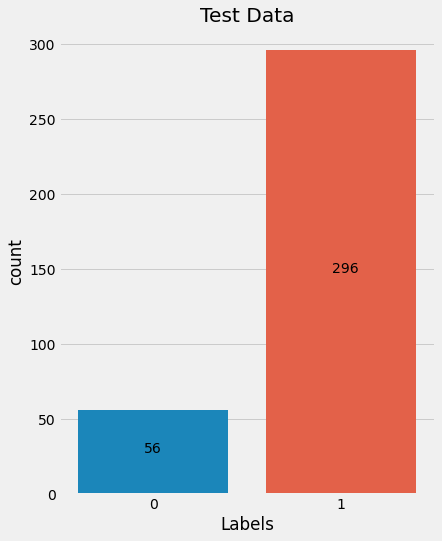

In [50]:
plt.figure(figsize = (6, 8))
fig = sns.countplot(test_pred)
for i in np.unique(test_pred):
    fig.annotate((test_pred == i).sum(), (i - 0.05, (test_pred == i).sum() // 2))
fig.set(title = 'Test Data')
fig.set_xlabel('Labels')
plt.show()

## Please write your observations at the end of notebook and  explain each and every step you followed in solving this assignment.

## **Observations**

In [51]:
from prettytable import PrettyTable

x = PrettyTable()

max_auc = round(max(mod.history['auc']), 4)
max_val_auc = round(max(mod.history['val_auc']), 4)
no_lr_change = len(set(mod.history['lr'])) - 1

x.field_names = ['Max.Train AUC Score', 'Max. Validation AUC Score',
                                 'No.of Epochs', 'No.of times learning rate changed']
x.add_row([max_auc, max_val_auc, EPOCHS, no_lr_change])

print(x)

+---------------------+---------------------------+--------------+-----------------------------------+
| Max.Train AUC Score | Max. Validation AUC Score | No.of Epochs | No.of times learning rate changed |
+---------------------+---------------------------+--------------+-----------------------------------+
|        0.9734       |           0.9644          |      20      |                 9                 |
+---------------------+---------------------------+--------------+-----------------------------------+


1. The given dataset `reviews.csv` is a highly unbalanced one.Beause of which a high AUC got during training.
2. On training the learning rate was frquently getting reduced with the help of `ReduceLROnPlateau` function.
3. The train score is constantly increasing and while the test scores were jumping with small deviations.
4. The result from `test.csv` also seems unbalanced one. More class points are for label 1.

**<font color='red'>Epoch AUC</font>**
<img src = 'https://i.imgur.com/jGd0J3K.png'><br><br><br>

**<font color='red'>Evaluation AUV vs Iterations</font>**
<img src = 'https://i.imgur.com/5nYrGpN.png'><br><br><br>

**<font color='red'>Epoch Loss</font>**
<img src = 'https://i.imgur.com/motxTQk.png'><br><br><br>

**<font color='red'>Graph</font>**
<img src = 'https://i.imgur.com/Lk9H947.png'>

